In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))


import pandas as pd
import numpy as np

from data_preparation.data_processor import DataProcessor
from models import XGBoostParams

import xgboost as xgb
import matplotlib.pyplot as plt


In [2]:
waste_data = pd.read_csv("../synthetic_waste_data.csv")

fetcher = DataProcessor(waste_data)

unique_companies = fetcher.waste_data['company'].unique()
company_dfs = {}

lags = [6,7,13,14,20,21]

for company in unique_companies:
    prep_data_company = fetcher.agg_quantity(company, by_company= True)
    company_dfs[company] = fetcher.create_xgboost_features(prep_data_company, lags=lags, lagged_features= True, lagged_ratios= False, trend_indicators=False)

for c, r in [('CommercialServices Inc', [0]), ('MunicipalWaste Co', [0, 1]), ('RegionalWaste Management', [-1])]:
    if c in company_dfs:
        n = company_dfs['GreenWaste Solutions'].iloc[r].copy()
        n['quantity_tons'], n.loc[:, n.columns.str.contains("lag")] = 0, np.nan
        company_dfs[c] = pd.concat([n, company_dfs[c]] if r != [-1] else [company_dfs[c], n]).sort_index()

for c in range(len(unique_companies)):
    company = list(company_dfs.keys())[c]
    print(f"Data shape for {company}:")
    print(company_dfs[company].shape)

Data shape for RegionalWaste Management:
(1075, 20)
Data shape for GreenWaste Solutions:
(1075, 20)
Data shape for IndustrialProcess Ltd:
(1075, 20)
Data shape for BuildRight Construction:
(1075, 20)
Data shape for CommercialServices Inc:
(1075, 20)
Data shape for MunicipalWaste Co:
(1075, 20)


In [3]:
split_index = int(company_dfs["RegionalWaste Management"].shape[0] * 0.75)


company_quantity_preds = {}

for company, df in company_dfs.items():
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Get the best parameters for this company
    best_params = XGBoostParams.get_company_params(company)
    
    # Create and train the model with best parameters
    best_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params  # Unpack the parameters
    )
    
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    company_quantity_preds[company] = y_pred

In [4]:
df = waste_data[["company","waste_type","quantity_tons","date"]].copy()
df_greenwaste = df[df["company"] == "GreenWaste Solutions"].copy()
df_greenwaste = df_greenwaste.drop("company", axis = 1)

df_greenwaste = df_greenwaste.groupby(['date', 'waste_type'])['quantity_tons'].sum().reset_index()
df_greenwaste = pd.DataFrame(df_greenwaste)
df_greenwaste = df_greenwaste.set_index("date")


df_greenwaste



,waste_type,quantity_tons
date,,
2022-01-01,Municipal,4.895075
2022-01-01,Organic,3.835948
2022-01-02,Organic,19.190867
2022-01-03,Organic,41.648117
2022-01-05,Organic,15.399205
...,...,...
2024-12-29,Municipal,6.269297
2024-12-29,Organic,17.377646
2024-12-30,Municipal,19.215939


In [5]:
df_greenwaste = df_greenwaste.pivot(columns =["waste_type"],values = "quantity_tons")

df_greenwaste = df_greenwaste.fillna(0)


date_range = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')


df_greenwaste.columns.name = ""
df_greenwaste = df_greenwaste.reset_index()
df_greenwaste["date"] = pd.to_datetime(df_greenwaste["date"])

n = len(date_range)
skeleton_df = pd.DataFrame({
    'date': date_range

})

skeleton_df["date"] = pd.to_datetime(skeleton_df["date"])

df_greenwaste = pd.merge(df_greenwaste, skeleton_df, how="outer", on = "date") 

df_greenwaste = df_greenwaste.set_index("date")
df_greenwaste = df_greenwaste.fillna(0)
df_greenwaste[split_index+lags[-1]:]

,Municipal,Organic
date,,
2024-04-07,14.606360,0.000000
2024-04-08,15.801609,18.852372
2024-04-09,9.684105,27.084600
2024-04-10,0.000000,17.736646
2024-04-11,0.000000,24.682995
...,...,...
2024-12-27,0.000000,69.235744
2024-12-28,22.843749,6.134864
2024-12-29,6.269297,17.377646


In [6]:

X_waste_ratios = waste_data[:split_index].copy()
X_waste_ratios["date"] = pd.to_datetime(X_waste_ratios["date"])

# Calculate monthly Ratios
X_waste_ratios['month'] = X_waste_ratios['date'].dt.to_period('M')
monthly_grouped = X_waste_ratios.groupby(['company', 'month', 'waste_type']).agg({'quantity_tons': 'sum'}).reset_index()
total_monthly_quantity_by_company = monthly_grouped.groupby(['company', 'month'])['quantity_tons'].transform('sum')
monthly_grouped['ratio'] = monthly_grouped['quantity_tons'] / total_monthly_quantity_by_company

# Calculate average ratio per company and waste type
avg_ratios = monthly_grouped.groupby(['company', 'waste_type'])['ratio'].mean().reset_index()

####################################################################################



avg_ratios_greenwaste = avg_ratios[avg_ratios["company"] == "GreenWaste Solutions"].reset_index()
avg_ratios_greenwaste




,index,company,waste_type,ratio
0,4,GreenWaste Solutions,Municipal,0.263033
1,5,GreenWaste Solutions,Organic,0.736967


In [7]:
pred_greenwaste_municipal = company_quantity_preds["GreenWaste Solutions"] * avg_ratios_greenwaste["ratio"][0]
pred_greenwaste_organic	= company_quantity_preds["GreenWaste Solutions"] * avg_ratios_greenwaste["ratio"][1]


In [8]:
from sklearn.metrics import root_mean_squared_error


rmse_municipal = root_mean_squared_error(df_greenwaste["Municipal"][split_index+lags[-1]:] , pred_greenwaste_municipal)
rmse_organic = root_mean_squared_error(df_greenwaste["Organic"][split_index+lags[-1]:],pred_greenwaste_organic)
print(f"Municipal:{round(rmse_municipal,2)}")
print(f"Organic:  {round(rmse_organic,2)}")

Municipal:10.07
Organic:  15.29


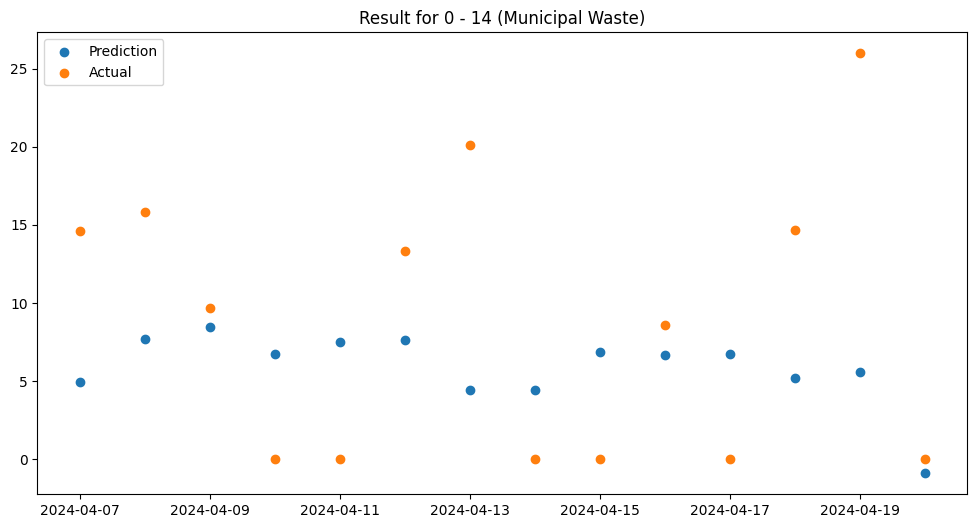

In [9]:
start = 0
end = 14

plt.figure(figsize=(12,6))

plt.scatter(y = pred_greenwaste_municipal[start:end],x = df_greenwaste.index[split_index+lags[-1]+ start:split_index+lags[-1]+end],  label ="Prediction")
plt.scatter(y = df_greenwaste["Municipal"][split_index+lags[-1]+start:split_index+lags[-1]+end],x = df_greenwaste.index[split_index+lags[-1]+start:split_index+lags[-1]+end], label = "Actual")
plt.title(f"Result for {start} - {end} (Municipal Waste)")
plt.legend()
plt.show()